<a href="https://colab.research.google.com/github/sayakpaul/SimCLR-in-TensorFlow-2/blob/imagenet-subset/Linear_Evaluation_Imageney_Subset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
print(tf.__version__)

2.2.0-rc4


In [2]:
!nvidia-smi

Fri May  8 12:30:55 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8     7W /  75W |      0MiB /  7611MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
from google.colab import auth
auth.authenticate_user()

PROJECT_ID = "fast-ai-exploration" 
!gcloud config set project $PROJECT_ID

In [4]:
!gsutil cp gs://resnet_simclr_imagenet/20200508-122626resnet_simclr.h5 .

Copying gs://resnet_simclr_imagenet/20200508-122626resnet_simclr.h5...
- [1 files][ 92.4 MiB/ 92.4 MiB]                                                
Operation completed over 1 objects/92.4 MiB.                                     


In [0]:
# Gather dataset
!git clone https://github.com/thunderInfy/imagenet-5-categories

In [0]:
# Other imports
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import matplotlib.pyplot as plt
from imutils import paths
from tqdm import tqdm
import tensorflow as tf
import seaborn as sns
import numpy as np
import cv2

# Random seed fixation
tf.random.set_seed(666)
np.random.seed(666)

In [7]:
# Train and test image paths
train_images = list(paths.list_images("imagenet-5-categories/train"))
test_images = list(paths.list_images("imagenet-5-categories/test"))
print(len(train_images), len(test_images))

1250 250


In [8]:
# 10% of the dataset
train_images_10 = np.random.choice(train_images, len(train_images)//10)
len(train_images_10)

125

In [0]:
def prepare_images(image_paths):
    images = []
    labels = []

    for image in tqdm(image_paths):
        image_pixels = plt.imread(image)
        image_pixels = cv2.resize(image_pixels, (224, 224))
        image_pixels = image_pixels/255.

        label = image.split("/")[2].split("_")[0]

        images.append(image_pixels)
        labels.append(label)

    images = np.array(images)
    labels = np.array(labels)

    print(images.shape, labels.shape)

    return images, labels

In [10]:
X_train, y_train = prepare_images(train_images_10)
X_test, y_test = prepare_images(test_images)

 10%|█         | 25/250 [00:00<00:00, 246.89it/s]

(125, 224, 224, 3) (125,)


100%|██████████| 250/250 [00:01<00:00, 229.49it/s]


(250, 224, 224, 3) (250,)


In [0]:
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

In [0]:
# Architecture utils
def get_resnet_simclr(hidden_1, hidden_2, hidden_3):
    base_model = tf.keras.applications.ResNet50(include_top=False, weights=None, input_shape=(224, 224, 3))
    base_model.trainabe = True
    inputs = Input((224, 224, 3))
    h = base_model(inputs, training=True)
    h = GlobalAveragePooling2D()(h)

    projection_1 = Dense(hidden_1)(h)
    projection_1 = Activation("relu")(projection_1)
    projection_2 = Dense(hidden_2)(projection_1)
    projection_2 = Activation("relu")(projection_2)
    projection_3 = Dense(hidden_3)(projection_2)

    resnet_simclr = Model(inputs, projection_3)

    return resnet_simclr

In [15]:
resnet_simclr = get_resnet_simclr(256, 128, 50)
resnet_simclr.load_weights("/content/20200508-122626resnet_simclr.h5")
resnet_simclr.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               524544    
_________________________________________________________________
activation (Activation)      (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
activation_1 (Activation)    (None, 128)               0     

In [0]:
def plot_training(H):
	with plt.xkcd():
		plt.plot(H.history["loss"], label="train_loss")
		plt.plot(H.history["val_loss"], label="val_loss")
		plt.plot(H.history["accuracy"], label="train_acc")
		plt.plot(H.history["val_accuracy"], label="val_acc")
		plt.title("Training Loss and Accuracy")
		plt.xlabel("Epoch #")
		plt.ylabel("Loss/Accuracy")
		plt.legend(loc="lower left")
		plt.show()

In [0]:
def get_linear_model(features):
    linear_model = Sequential([Dense(5, input_shape=(features, ), activation="softmax")])
    return linear_model

In [18]:
# Encoder model with non-linear projections
projection = Model(resnet_simclr.input, resnet_simclr.layers[-2].output)

# Extract train and test features
train_features = projection.predict(X_train)
test_features = projection.predict(X_test)

print(train_features.shape, test_features.shape)

(125, 128) (250, 128)


In [0]:
# Early Stopping to prevent overfitting
es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=2, verbose=2, restore_best_weights=True)

Epoch 1/35
2/2 [==============================] - 0s 74ms/step - loss: 4.6336 - accuracy: 0.0640 - val_loss: 4.3472 - val_accuracy: 0.0800
Epoch 2/35
2/2 [==============================] - 0s 16ms/step - loss: 4.4148 - accuracy: 0.0640 - val_loss: 4.1494 - val_accuracy: 0.0840
Epoch 3/35
2/2 [==============================] - 0s 16ms/step - loss: 4.1986 - accuracy: 0.0640 - val_loss: 3.9604 - val_accuracy: 0.0880
Epoch 4/35
2/2 [==============================] - 0s 16ms/step - loss: 4.0044 - accuracy: 0.0640 - val_loss: 3.7783 - val_accuracy: 0.0880
Epoch 5/35
2/2 [==============================] - 0s 16ms/step - loss: 3.8216 - accuracy: 0.0640 - val_loss: 3.6038 - val_accuracy: 0.0960
Epoch 6/35
2/2 [==============================] - 0s 17ms/step - loss: 3.6428 - accuracy: 0.0720 - val_loss: 3.4379 - val_accuracy: 0.1080
Epoch 7/35
2/2 [==============================] - 0s 16ms/step - loss: 3.4728 - accuracy: 0.0720 - val_loss: 3.2836 - val_accuracy: 0.1080
Epoch 8/35
2/2 [===========

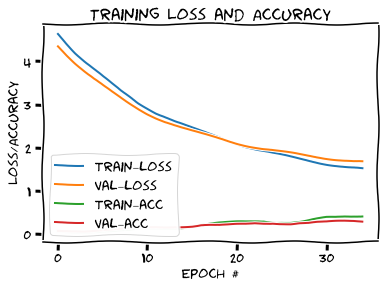

In [21]:
# Linear model
linear_model = get_linear_model(128)
linear_model.compile(loss="sparse_categorical_crossentropy", metrics=["accuracy"],
                     optimizer="adam")
history = linear_model.fit(train_features, y_train_enc,
                 validation_data=(test_features, y_test_enc),
                 batch_size=64,
                 epochs=35,
                 callbacks=[es])
plot_training(history)

In [22]:
# Encoder model with less non-linearity
projection = Model(resnet_simclr.input, resnet_simclr.layers[-4].output)

# Extract train and test features
train_features = projection.predict(X_train)
test_features = projection.predict(X_test)

print(train_features.shape, test_features.shape)

(125, 256) (250, 256)


Epoch 1/35
2/2 [==============================] - 0s 45ms/step - loss: 5.9997 - accuracy: 0.1760 - val_loss: 4.7810 - val_accuracy: 0.2200
Epoch 2/35
2/2 [==============================] - 0s 18ms/step - loss: 5.2314 - accuracy: 0.1760 - val_loss: 4.0923 - val_accuracy: 0.2240
Epoch 3/35
2/2 [==============================] - 0s 16ms/step - loss: 4.5195 - accuracy: 0.1840 - val_loss: 3.5022 - val_accuracy: 0.2280
Epoch 4/35
2/2 [==============================] - 0s 16ms/step - loss: 3.9041 - accuracy: 0.2080 - val_loss: 3.0323 - val_accuracy: 0.2360
Epoch 5/35
2/2 [==============================] - 0s 16ms/step - loss: 3.4235 - accuracy: 0.2000 - val_loss: 2.6911 - val_accuracy: 0.2680
Epoch 6/35
2/2 [==============================] - 0s 16ms/step - loss: 3.0486 - accuracy: 0.2080 - val_loss: 2.4502 - val_accuracy: 0.2800
Epoch 7/35
2/2 [==============================] - 0s 18ms/step - loss: 2.7288 - accuracy: 0.2080 - val_loss: 2.2758 - val_accuracy: 0.2600
Epoch 8/35
2/2 [===========

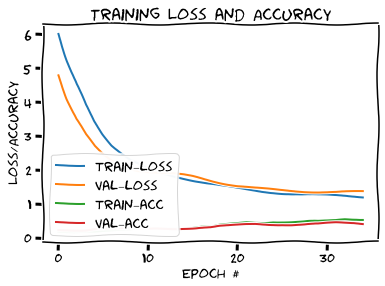

In [23]:
linear_model = get_linear_model(256)
linear_model.compile(loss="sparse_categorical_crossentropy", metrics=["accuracy"],
                     optimizer="adam")
history = linear_model.fit(train_features, y_train_enc,
                 validation_data=(test_features, y_test_enc),
                 batch_size=64,
                 epochs=35,
                 callbacks=[es])
plot_training(history)

In [24]:
# Encoder model with no projection
projection = Model(resnet_simclr.input, resnet_simclr.layers[-6].output)

# Extract train and test features
train_features = projection.predict(X_train)
test_features = projection.predict(X_test)

print(train_features.shape, test_features.shape)

(125, 2048) (250, 2048)


Epoch 1/35
2/2 [==============================] - 0s 49ms/step - loss: 2.2096 - accuracy: 0.1920 - val_loss: 2.3593 - val_accuracy: 0.2960
Epoch 2/35
2/2 [==============================] - 0s 18ms/step - loss: 2.0981 - accuracy: 0.3280 - val_loss: 1.7255 - val_accuracy: 0.2240
Epoch 3/35
2/2 [==============================] - 0s 19ms/step - loss: 1.7452 - accuracy: 0.2720 - val_loss: 1.4913 - val_accuracy: 0.3680
Epoch 4/35
2/2 [==============================] - 0s 19ms/step - loss: 1.4812 - accuracy: 0.3040 - val_loss: 1.4842 - val_accuracy: 0.4040
Epoch 5/35
2/2 [==============================] - 0s 18ms/step - loss: 1.4241 - accuracy: 0.4320 - val_loss: 1.5737 - val_accuracy: 0.3880
Epoch 6/35
2/2 [==============================] - 0s 19ms/step - loss: 1.3594 - accuracy: 0.4560 - val_loss: 1.3802 - val_accuracy: 0.4120
Epoch 7/35
2/2 [==============================] - 0s 18ms/step - loss: 1.2271 - accuracy: 0.4720 - val_loss: 1.2878 - val_accuracy: 0.4760
Epoch 8/35
2/2 [===========

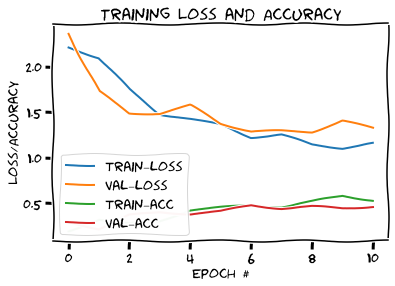

In [25]:
linear_model = get_linear_model(2048)
linear_model.compile(loss="sparse_categorical_crossentropy", metrics=["accuracy"],
                     optimizer="adam")
history = linear_model.fit(train_features, y_train_enc,
                 validation_data=(test_features, y_test_enc),
                 batch_size=64,
                 epochs=35,
                 callbacks=[es])
plot_training(history)